### Import libraries

In [182]:
from __future__ import print_function, division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import time
import os
import copy
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid

% matplotlib inline
warnings.filterwarnings('ignore')

## Dataloader

In [165]:
class TwinsDataloader(Dataset):
    def __init__(self, dataroot, df, transform):
        '''
        dataroot: path to folder with items
        df: pandas dataframe with fields view, id_a, id_b
        transform: torchvision transform
        '''
        self.dataroot = dataroot
        self.df = df
        self.transform = transform

    def __getitem__(self, index):
        
        def get_img_path(img_id, view):
            #return os.path.join(self.dataroot, f'{img_id}/{img_id}d{view}__face.jpg')
            return self.dataroot+f'{img_id}/{img_id}d{view}__face.jpg'
        
        #print(self.df.iloc[index].values[0])
        
        view, id_a, id_b  = self.df.iloc[index].values
        #print(view)
        #view = np.random.choice(views)
        #print(view, id_a, id_b)
        
        path_a = get_img_path(id_a, view)
        path_b = get_img_path(id_b, view)

        img_a = Image.open(path_a)
        img_b = Image.open(path_b)

        #plt.imshow(img_a)
        #plt.show()
        #plt.imshow(img_b)
        
        img_a = self.transform(img_a)
        img_b = self.transform(img_b)
        
        return {'img_a': img_a, 'img_b': img_b, 'class_a':id_a,'class_b':id_b}#'A_paths': path_a, 'B_paths': path_b }

    def __len__(self):
        return self.df.shape[0]

In [168]:
#for testing
df_train=pd.DataFrame({'view':np.random.randint(8,12,7),'id_a':[90100 for x in range(1,8)],'id_b':[90100 for x in range(1,8)]})

In [169]:
df_train

,view,id_a,id_b
0,9,90100,90100
1,8,90100,90100
2,10,90100,90100
3,9,90100,90100
4,10,90100,90100
5,9,90100,90100
6,11,90100,90100


In [170]:
data_transforms = {
    'train': transforms.Compose([
             transforms.CenterCrop(224),
             transforms.ToTensor(),
             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
           transforms.Resize(224),
           transforms.CenterCrop(224),
           transforms.ToTensor(),
           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [177]:
direct='./nd-twins-0006/faces/'
twins_dataset = TwinsDataloader(direct, df_train, data_transforms['train'])

#twins_dataset.__getitem__(0)

dataset = DataLoader(twins_dataset, batch_size=4,shuffle=True)

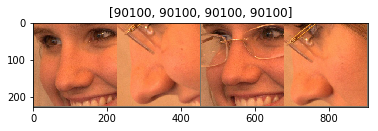

In [178]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
T = next(iter(dataset))
#print(T)
classes=T['class_a'].numpy()
inputs=T['img_a']

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[x for x in classes])

## Train

In [186]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [180]:
#df=pd.read_csv('twins-relationship-info.csv', index_col=0)
#df

In [196]:
from model import MobileFaceNet

model = MobileFaceNet(embedding_size=512)

PATH = os.path.join(os.getcwd(),"model_mobilefacenet.pth")

checkpoint = torch.load(PATH,map_location=device)

model.load_state_dict(checkpoint)

optimizer = optim.SGD(model.parameters(),lr=0.1)

In [195]:
print(inputs.shape)

torch.Size([4, 3, 224, 224])


In [193]:
model(inputs)

RuntimeError: size mismatch, m1: [4 x 32768], m2: [512 x 512] at c:\a\w\1\s\tmp_conda_3.6_061433\conda\conda-bld\pytorch_1544163532679\work\aten\src\th\generic/THTensorMath.cpp:940

In [ ]:
## This class for choosing the layers you need
class ModelBottom(nn.Module):
    def __init__(self, original_model):
        super(ModelBottom, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-2])
        
    def forward(self, x):
        x = self.features(x)
        return x


model_flatten = ModelBottom(model)
inputs, labels = next(iter(dataloaders['train']))
outputs = model_flatten(inputs)
outputs.data.shape  

In [190]:
classes=os.listdir(direct)

In [ ]:
model_flatten.classifier = nn.Sequential(
                      nn.Linear(hid_size, 256),
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, n_classes),                   
                      nn.LogSoftmax(dim=1))

In [ ]:
def train():